# Exploratory Data Analysis (EDA) Multimodal
Tujuan: memahami data multimodal (audio, MIDI, lirik) untuk menemukan pola, masalah kualitas, dan kesiapan fitur.


In [1]:
# Import library untuk EDA dan visualisasi multimodal
import os  # operasi sistem dan path
import numpy as np  # komputasi numerik
import pandas as pd  # manipulasi data tabular
import matplotlib.pyplot as plt  # visualisasi
import seaborn as sns  # heatmap/korelasi
from sklearn.preprocessing import StandardScaler  # standardisasi fitur
from sklearn.decomposition import PCA  # reduksi dimensi linear
from sklearn.manifold import TSNE  # reduksi dimensi non-linear (t-SNE)
from sklearn.feature_extraction.text import TfidfVectorizer  # representasi teks (lyric) berbasis TF-IDF
import librosa  # pemrosesan dan ekstraksi fitur audio
import pretty_midi  # pemrosesan dan ekstraksi fitur MIDI (pip install pretty_midi jika belum terpasang)


In [2]:
# Placeholder inisialisasi variabel t-SNE/PCA
X_audio_pca = locals().get('X_audio_pca', np.array([]))
X_audio_tsne = locals().get('X_audio_tsne', np.array([]))
X_midi_pca = locals().get('X_midi_pca', np.array([]))
X_midi_tsne = locals().get('X_midi_tsne', np.array([]))
X_lyrics_pca = locals().get('X_lyrics_pca', np.array([]))
X_lyrics_tsne = locals().get('X_lyrics_tsne', np.array([]))


## 0. Setup & pengecekan path

In [3]:
# Atur path root dataset (ubah jika lokasi berbeda)
root_dir = r"D:\Se\Multimodal\TUBES\dataset"  # ganti sesuai lokasi dataset Anda

# Tampilkan isi folder agar tahu nama subfolder dan file yang tersedia
print("Isi root_dir:")
for item in os.listdir(root_dir):
    print('-', item)

# Catatan: jika nama folder atau file berbeda, sesuaikan di cell berikutnya.

Isi root_dir:
- Audio
- categories.txt
- clusters.txt
- dataset info.csv
- dataset info.html
- Lyrics
- MIDIs
- split-by-categories-audio.bat
- split-by-categories-lyrics.bat
- split-by-categories-midi.bat


## 1. Metadata & target label

In [4]:
# Set path untuk folder audio, MIDI, lirik, dan file metadata/label
# Ganti nama folder jika berbeda (huruf besar/kecil di Windows tidak masalah, di Linux sensitif)
audio_dir = os.path.join(root_dir, "Audio")
midi_dir = os.path.join(root_dir, "MIDIs")
lyrics_dir = os.path.join(root_dir, "Lyrics")

# File metadata utama bernama "dataset info.csv"
csv_path = os.path.join(root_dir, "dataset info.csv")

# Label kategori emosi utama
cat_path = os.path.join(root_dir, "categories.txt")

# Label alternatif (clusters)
cluster_path = os.path.join(root_dir, "clusters.txt")

print("Folder audio:", audio_dir)
print("Folder MIDI:", midi_dir)
print("Folder lyrics:", lyrics_dir)
print("File metadata CSV:", csv_path)
print("File label emosi:", cat_path)
print("File label clusters:", cluster_path)

Folder audio: D:\Se\Multimodal\TUBES\dataset\Audio
Folder MIDI: D:\Se\Multimodal\TUBES\dataset\MIDIs
Folder lyrics: D:\Se\Multimodal\TUBES\dataset\Lyrics
File metadata CSV: D:\Se\Multimodal\TUBES\dataset\dataset info.csv
File label emosi: D:\Se\Multimodal\TUBES\dataset\categories.txt
File label clusters: D:\Se\Multimodal\TUBES\dataset\clusters.txt


In [5]:
# Baca metadata CSV dan file label (kategori + cluster)
metadata = pd.read_csv(csv_path, sep=';', engine='python', encoding='utf-16', on_bad_lines='skip')

# Bersihkan kolom yang tidak diperlukan
if 'Unnamed: 9' in metadata.columns:
    metadata = metadata.drop(columns=['Unnamed: 9'])

# Samakan nama kolom filename agar konsisten
if 'Filename' in metadata.columns:
    metadata = metadata.rename(columns={'Filename': 'filename'})

# Baca label emosi dari categories.txt
with open(cat_path, 'r', encoding='latin-1') as f:
    categories = [line.strip() for line in f if line.strip()]

# Baca label cluster dari clusters.txt
with open(cluster_path, 'r', encoding='latin-1') as f:
    clusters = [line.strip() for line in f if line.strip()]

# Samakan panjang metadata dan label (jaga-jaga jika ada baris rusak)
min_len = min(len(metadata), len(categories), len(clusters))
if len({len(metadata), len(categories), len(clusters)}) != 1:
    print(f"Peringatan: panjang metadata ({len(metadata)}), categories ({len(categories)}), clusters ({len(clusters)}); memakai {min_len} baris pertama.")
metadata = metadata.iloc[:min_len].copy()
metadata['label'] = categories[:min_len]
metadata['cluster'] = clusters[:min_len]

print("Head metadata:")
print(metadata.head())
print("Kolom tersedia:", list(metadata.columns))

# Pastikan kolom nama file audio ("filename") dan kolom label ("label"/"cluster") sudah ada.

Peringatan: panjang metadata (902), categories (903), clusters (903); memakai 902 baris pertama.
Head metadata:
                                 Title                             Artist  \
0  (Mama) He Treats Your Daughter Mean                        Brown, Ruth   
1                     Night in Tunisia  Blakey, Art & the Jazz Messengers   
2                     Along Came Jones                           Coasters   
3                        Back in Black                              AC/DC   
4                       Bad Reputation       Jett, Joan & Teh Blackhearts   

                             Album  Track    Year  Length       Size  \
0       Best of Ruth Brown [Rhino]    8.0  1996.0      30  352,00 KB   
1          Night in Tunisia [1960]    1.0  1960.0      30  348,00 KB   
2  50 Coastin' Classics: Anthology   27.0  1992.0      30  352,00 KB   
3                    Back in Black    6.0  1980.0      30  352,00 KB   
4    Bad Reputation [Bonus Tracks]    1.0  1992.0      29  340,00

In [6]:
# Helper normalisasi label/cluster agar bukan array
import numpy as np

def normalize_label(val):
    if isinstance(val, (list, np.ndarray)):
        flat = np.array(val).flatten()
        return str(flat[0]) if flat.size > 0 else ''
    return str(val)

def normalize_series(series):
    return series.apply(normalize_label).astype(str)


In [7]:
# Ringkasan metadata awal: ukuran, duplikasi, dan missing
print("Dimensi metadata:", metadata.shape)
print("Tipe kolom:")
print(metadata.dtypes)
if 'filename' in metadata.columns:
    dup_filename = metadata['filename'].duplicated().sum()
    print(f"Jumlah duplikat filename: {dup_filename}")
else:
    dup_filename = 0
print("Jumlah missing per kolom:")
print(metadata.isna().sum())


Dimensi metadata: (902, 11)
Tipe kolom:
Title             object
Artist            object
Album             object
Track            float64
Year             float64
Length             int64
Size              object
Last Modified     object
filename          object
label             object
cluster           object
dtype: object
Jumlah duplikat filename: 0
Jumlah missing per kolom:
Title            6
Artist           6
Album            6
Track            6
Year             6
Length           0
Size             0
Last Modified    0
filename         0
label            0
cluster          0
dtype: int64


Top 5 label:
label
Passionate     40
Literate       39
Campy          38
Bittersweet    38
Confident      37
Name: count, dtype: int64
Rasio imbalance label teratas vs terbawah: 1.82x


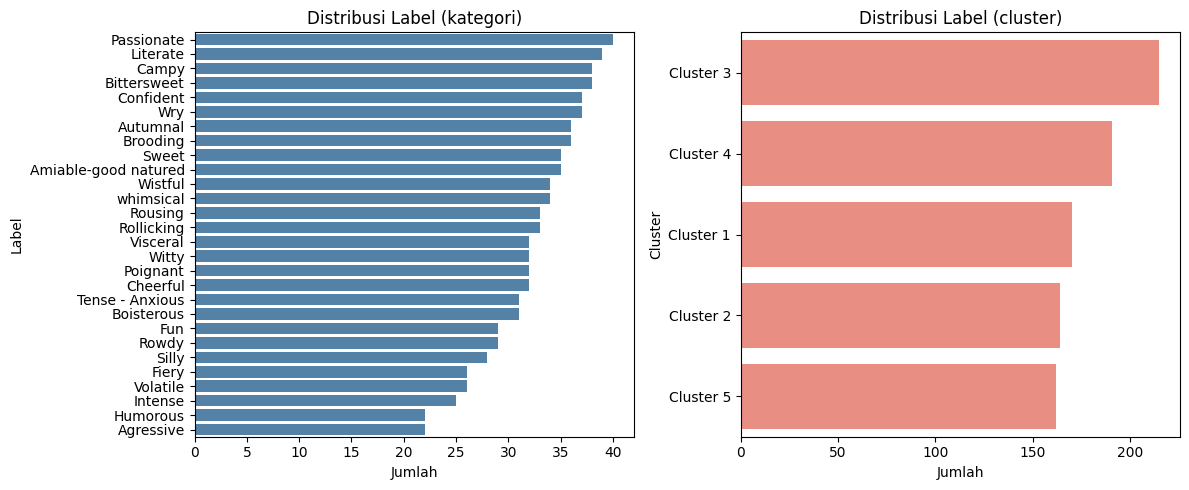

In [8]:
# Distribusi label kategori dan cluster (target analysis)
label_counts = metadata['label'].value_counts().sort_values(ascending=False)
cluster_counts = metadata['cluster'].value_counts().sort_values(ascending=False)

print("Top 5 label:")
print(label_counts.head())
if label_counts.shape[0] > 0 and label_counts.min() > 0:
    imbalance_ratio = label_counts.max() / label_counts.min()
    print(f"Rasio imbalance label teratas vs terbawah: {imbalance_ratio:.2f}x")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=label_counts.values, y=label_counts.index, ax=axes[0], color='steelblue')
axes[0].set_title('Distribusi Label (kategori)')
axes[0].set_xlabel('Jumlah')
axes[0].set_ylabel('Label')

sns.barplot(x=cluster_counts.values, y=cluster_counts.index, ax=axes[1], color='salmon')
axes[1].set_title('Distribusi Label (cluster)')
axes[1].set_xlabel('Jumlah')
axes[1].set_ylabel('Cluster')

plt.tight_layout()
plt.show()


In [9]:
# Analisa sementara distribusi target
print(f"Total sampel: {len(metadata)}")
if len(label_counts) > 0:
    print(f"Label dominan: {label_counts.idxmax()} ({label_counts.max()} sampel)")
    print(f"Label terjarang: {label_counts.idxmin()} ({label_counts.min()} sampel)")
print("Rangkuman cluster (5 teratas):")
print(cluster_counts.head())


Total sampel: 902
Label dominan: Passionate (40 sampel)
Label terjarang: Humorous (22 sampel)
Rangkuman cluster (5 teratas):
cluster
Cluster 3    215
Cluster 4    191
Cluster 1    170
Cluster 2    164
Cluster 5    162
Name: count, dtype: int64


## 2. Kualitas data & kelengkapan modal

In [10]:
# Cek ketersediaan berkas per modal dibanding metadata
base_names = metadata['filename'].astype(str).apply(lambda x: os.path.splitext(x)[0])
audio_files = set([os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.lower().endswith('.mp3')])
midi_files = set([os.path.splitext(f)[0] for f in os.listdir(midi_dir) if f.lower().endswith('.mid')])
lyrics_files = set([os.path.splitext(f)[0] for f in os.listdir(lyrics_dir) if f.lower().endswith('.txt')])

missing_audio = [b for b in base_names if b not in audio_files]
missing_midi = [b for b in base_names if b not in midi_files]
missing_lyrics = [b for b in base_names if b not in lyrics_files]

summary_avail = pd.DataFrame({
    'modalitas': ['Audio', 'MIDI', 'Lyrics'],
    'tersedia': [len(audio_files), len(midi_files), len(lyrics_files)],
    'hilang_vs_metadata': [len(missing_audio), len(missing_midi), len(missing_lyrics)]
})
summary_avail['persentase_tersedia'] = summary_avail['tersedia'] / len(base_names) * 100
print(summary_avail)

print(f"Total baris metadata: {len(base_names)}")
print(f"Audio tersedia: {len(audio_files)} ({len(base_names) - len(missing_audio)} cocok dengan metadata) | hilang: {len(missing_audio)}")
print(f"MIDI tersedia: {len(midi_files)} ({len(base_names) - len(missing_midi)} cocok dengan metadata) | hilang: {len(missing_midi)}")
print(f"Lyrics tersedia: {len(lyrics_files)} ({len(base_names) - len(missing_lyrics)} cocok dengan metadata) | hilang: {len(missing_lyrics)}")
print("Contoh missing MIDI:", missing_midi[:10])
print("Contoh missing Lyrics:", missing_lyrics[:10])


  modalitas  tersedia  hilang_vs_metadata  persentase_tersedia
0     Audio       903                   0           100.110865
1      MIDI       196                 706            21.729490
2    Lyrics       764                 138            84.700665
Total baris metadata: 902
Audio tersedia: 903 (902 cocok dengan metadata) | hilang: 0
MIDI tersedia: 196 (196 cocok dengan metadata) | hilang: 706
Lyrics tersedia: 764 (764 cocok dengan metadata) | hilang: 138
Contoh missing MIDI: ['001', '002', '003', '005', '006', '007', '010', '011', '013', '014']
Contoh missing Lyrics: ['002', '005', '006', '014', '018', '023', '026', '031', '035', '047']


In [11]:
# Analisa sementara kualitas data
coverage_audio = len(base_names) - len(missing_audio)
coverage_midi = len(base_names) - len(missing_midi)
coverage_lyrics = len(base_names) - len(missing_lyrics)
print(f"Audio coverage: {coverage_audio}/{len(base_names)} ({coverage_audio/len(base_names)*100:.1f}%)")
print(f"MIDI coverage: {coverage_midi}/{len(base_names)} ({coverage_midi/len(base_names)*100:.1f}%)")
print(f"Lyrics coverage: {coverage_lyrics}/{len(base_names)} ({coverage_lyrics/len(base_names)*100:.1f}%)")
print("Catatan: modal dengan coverage rendah mungkin tidak cocok untuk modelling awal tanpa imputasi/penyelarasan.")


Audio coverage: 902/902 (100.0%)
MIDI coverage: 196/902 (21.7%)
Lyrics coverage: 764/902 (84.7%)
Catatan: modal dengan coverage rendah mungkin tidak cocok untuk modelling awal tanpa imputasi/penyelarasan.


## 3A. Analisis intra-modal: Audio

In [12]:
# Ekstraksi fitur audio (MFCC) tanpa encoder deep learning
def _to_str(val):
    if isinstance(val, (list, np.ndarray)):
        flat = np.array(val).flatten()
        return str(flat[0]) if flat.size > 0 else ''
    return str(val)

audio_ids = []
feature_list = []
label_list = []
cluster_list = []
audio_durations = []

for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    audio_path = os.path.join(audio_dir, str(row['filename']))

    if not os.path.isfile(audio_path):
        continue  # skip jika file tidak ada

    try:
        signal, sr = librosa.load(audio_path, sr=None)
        duration_sec = len(signal) / sr

        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std])

        feature_list.append(features)
        label_list.append(_to_str(row['label']))
        cluster_list.append(_to_str(row['cluster']))
        audio_durations.append(duration_sec)
        audio_ids.append(base)
    except Exception as e:
        print(f"Gagal memproses {audio_path}: {e}")
        continue

X_audio = np.array(feature_list)
y_audio = np.array(label_list, dtype=object)
y_audio_cluster = np.array(cluster_list, dtype=object)
audio_durations = np.array(audio_durations)

print("Shape fitur X_audio:", X_audio.shape)
print("Contoh label kategori:", y_audio[:10])
print("Contoh durasi audio (detik):", audio_durations[:5])


Shape fitur X_audio: (902, 40)
Contoh label kategori: ['Boisterous' 'Boisterous' 'Boisterous' 'Boisterous' 'Boisterous'
 'Boisterous' 'Boisterous' 'Boisterous' 'Boisterous' 'Boisterous']
Contoh durasi audio (detik): [29.62866213 29.58222222 29.76798186 29.67510204 28.88562358]


Deskripsi durasi audio:
count    902.000000
mean      29.638126
std        0.359227
min       26.656508
25%       29.628662
50%       29.675102
75%       29.721542
max       30.046621
Name: duration, dtype: float64


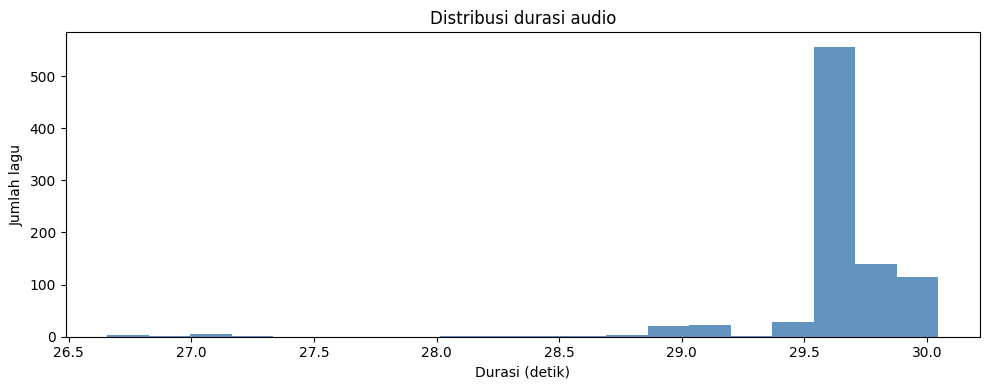

Rata-rata durasi per label (top 8):
label
Fun                29.724745
Campy              29.721542
Rollicking         29.714506
Rowdy              29.707130
Passionate         29.701878
Wry                29.693929
Autumnal           29.692840
Tense - Anxious    29.691581
Name: duration, dtype: float64


In [13]:
# Statistik dasar audio: durasi dan distribusi per label
audio_df = pd.DataFrame({
    'id': audio_ids,
    'label': y_audio,
    'cluster': y_audio_cluster,
    'duration': audio_durations
})

if not audio_df.empty:
    audio_df['label'] = normalize_series(audio_df['label'])
    audio_df['cluster'] = normalize_series(audio_df['cluster'])
    print("Deskripsi durasi audio:")
    print(audio_df['duration'].describe())

    plt.figure(figsize=(10, 4))
    plt.hist(audio_df['duration'], bins=20, color='steelblue', alpha=0.85)
    plt.xlabel('Durasi (detik)')
    plt.ylabel('Jumlah lagu')
    plt.title('Distribusi durasi audio')
    plt.tight_layout()
    plt.show()

    print("Rata-rata durasi per label (top 8):")
    print(audio_df.groupby('label')['duration'].mean().sort_values(ascending=False).head(8))
else:
    print("Tidak ada audio yang berhasil diproses.")


In [14]:
# Analisa sementara audio
if not audio_df.empty:
    print(f"Audio tersedia untuk {len(audio_df)} lagu; median durasi {audio_df['duration'].median():.2f} detik.")
    print("Label dengan sampel audio terbanyak:")
    print(audio_df['label'].value_counts().head())
else:
    print("Audio tidak tersedia sehingga perlu cek ulang path atau isi dataset.")


Audio tersedia untuk 902 lagu; median durasi 29.68 detik.
Label dengan sampel audio terbanyak:
label
Passionate     40
Literate       39
Campy          38
Bittersweet    38
Confident      37
Name: count, dtype: int64


### Fitur tambahan audio (ritme/spektral) & deteksi anomali

In [15]:
# Fitur audio tambahan (bass/energi/ritme) + deteksi anomali sederhana
import re

audio_extra = []
for _, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    audio_path = os.path.join(audio_dir, str(row['filename']))
    if not os.path.isfile(audio_path):
        continue
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        S = np.abs(librosa.stft(y, n_fft=2048))
        freqs = librosa.fft_frequencies(sr=sr)
        low_mask = (freqs <= 150)
        bass_ratio = S[low_mask, :].mean() / (S.mean() + 1e-8)
        centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
        rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85).mean()
        zcr = librosa.feature.zero_crossing_rate(y).mean()
        rms = librosa.feature.rms(S=S).mean()
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        onset_count = librosa.onset.onset_detect(y=y, sr=sr, units="time").size
        duration = len(y) / sr
        onset_rate = onset_count / (duration + 1e-8)
        audio_extra.append({
            'id': base,
            'label': normalize_label(row['label']),
            'cluster': normalize_label(row['cluster']),
            'bass_ratio': bass_ratio,
            'centroid': centroid,
            'rolloff': rolloff,
            'zcr': zcr,
            'rms': rms,
            'tempo': tempo,
            'onset_rate': onset_rate,
            'duration': duration
        })
    except Exception as e:
        print(f"Gagal fitur ekstra {audio_path}: {e}")

audio_extra_df = pd.DataFrame(audio_extra)
if audio_extra_df.empty:
    print("Fitur ekstra audio kosong.")
else:
    audio_extra_df['label'] = normalize_series(audio_extra_df['label'])
    audio_extra_df['cluster'] = normalize_series(audio_extra_df['cluster'])
    print(audio_extra_df.describe().T[['mean', 'std', 'min', 'max']])
    q_low, q_high = audio_extra_df['rms'].quantile([0.01, 0.99])
    low_rms = audio_extra_df[audio_extra_df['rms'] < q_low][['id', 'rms']].head(10)
    high_rms = audio_extra_df[audio_extra_df['rms'] > q_high][['id', 'rms']].head(10)
    print("Contoh RMS sangat rendah (mungkin silent):", low_rms.to_dict('records'))
    print("Contoh RMS sangat tinggi (mungkin clipping):", high_rms.to_dict('records'))


                   mean          std          min          max
bass_ratio     7.552831     3.471027     0.238377    25.456635
centroid    2290.449565   567.879983   739.852684  4094.743559
rolloff     4702.080250  1197.785780  1036.742076  7805.052236
zcr            0.112496     0.039822     0.026821     0.279865
rms            0.072785     0.023553     0.009076     0.180933
onset_rate     4.033427     0.966423     0.842457     7.211433
duration      29.638126     0.359227    26.656508    30.046621
Contoh RMS sangat rendah (mungkin silent): [{'id': '293', 'rms': 0.022387390863393974}, {'id': '389', 'rms': 0.02168698517606279}, {'id': '392', 'rms': 0.02362712715056204}, {'id': '558', 'rms': 0.009075655564268845}, {'id': '561', 'rms': 0.028774925317475594}, {'id': '592', 'rms': 0.0131484135508884}, {'id': '609', 'rms': 0.023599505972130785}, {'id': '773', 'rms': 0.02863436844231135}, {'id': '812', 'rms': 0.027234299038754472}, {'id': '825', 'rms': 0.028283487523634333}]
Contoh RMS sangat

### Reduksi dimensi & t-SNE audio

In [16]:
# Standardisasi fitur audio
scaler_audio = StandardScaler()
X_audio_scaled = scaler_audio.fit_transform(X_audio)

print("Shape X_audio_scaled:", X_audio_scaled.shape)
# Standardisasi membantu algoritma berbasis jarak (seperti PCA dan t-SNE) bekerja lebih stabil.

Shape X_audio_scaled: (902, 40)


In [17]:
# Reduksi dimensi awal dengan PCA sebelum t-SNE (audio)
pca_audio = PCA(n_components=30, random_state=42)
X_audio_pca = pca_audio.fit_transform(X_audio_scaled)

print("Shape X_audio_pca:", X_audio_pca.shape)
explained_var_audio = np.sum(pca_audio.explained_variance_ratio_)
print(f"Total variansi yang dijelaskan 30 komponen pertama: {explained_var_audio:.2%}")

# PCA membantu mereduksi noise dan mempercepat t-SNE dengan mempertahankan informasi utama.

Shape X_audio_pca: (902, 30)
Total variansi yang dijelaskan 30 komponen pertama: 95.56%


In [18]:
# t-SNE utama (audio) seluruh data, auto-sesuaikan perplexity dan compat n_iter/max_iter
# Gunakan perplexity menyesuaikan jumlah sampel dan hindari error pada TSNE versi lama
import inspect

n_samples = X_audio_pca.shape[0]
if n_samples < 5:
    raise ValueError("Data audio terlalu sedikit untuk t-SNE (butuh >=5 sampel).")

perp = min(30, max(5, n_samples // 3 - 1))

tsne_params = dict(
    n_components=2,
    perplexity=float(perp),
    learning_rate=200,
    random_state=42,
    init='pca'
)

sig_params = inspect.signature(TSNE).parameters
iter_param = None
if 'n_iter' in sig_params:
    tsne_params['n_iter'] = 1000
    iter_param = 'n_iter'
elif 'max_iter' in sig_params:
    tsne_params['max_iter'] = 1000
    iter_param = 'max_iter'

_tsne_audio = TSNE(**tsne_params)
X_audio_tsne = _tsne_audio.fit_transform(X_audio_pca)

print("Shape X_audio_tsne:", X_audio_tsne.shape)
print(f"Perplexity yang dipakai: {perp}")
if iter_param:
    print(f"Iterasi t-SNE di-set via {iter_param}=1000")
else:
    print("Peringatan: TSNE versi ini tidak mengekspos n_iter/max_iter; pakai default bawaan.")

# Parameter utama t-SNE:
# - perplexity: kira-kira jumlah tetangga efektif yang diperhatikan (skala lokal)
# - learning_rate: kecepatan pembaruan posisi
# - n_iter/max_iter: jumlah iterasi optimisasi (dipakai jika tersedia)


Shape X_audio_tsne: (902, 2)
Perplexity yang dipakai: 30
Iterasi t-SNE di-set via max_iter=1000


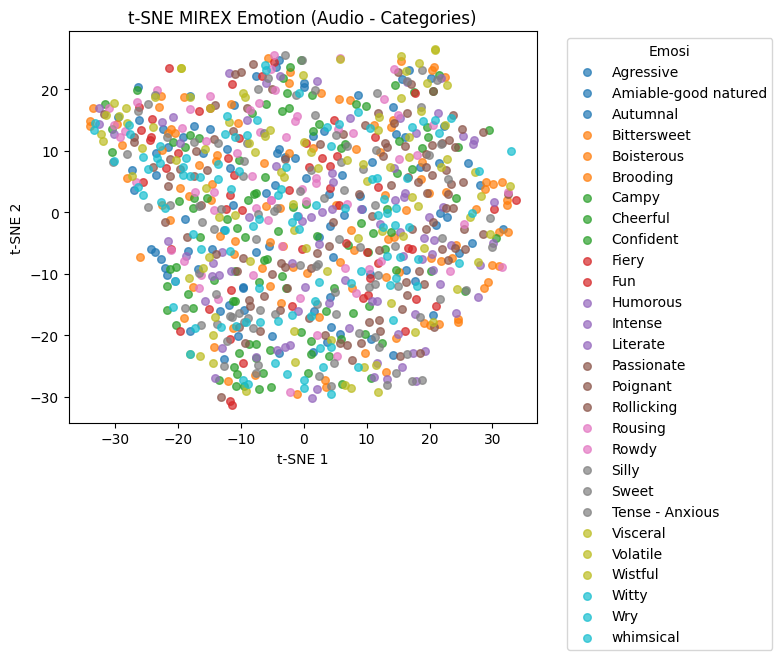

In [19]:
# Visualisasi t-SNE audio berwarna sesuai label kategori
plt.figure(figsize=(8, 6))
unique_labels = np.unique(y_audio)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: color for label, color in zip(unique_labels, colors)}

for label in unique_labels:
    mask = y_audio == label
    plt.scatter(X_audio_tsne[mask, 0], X_audio_tsne[mask, 1],
                color=label_to_color[label], alpha=0.7, label=label, s=30)

plt.title('t-SNE MIREX Emotion (Audio - Categories)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Titik yang dekat merepresentasikan klip audio dengan pola MFCC mirip; warna = kategori emosi.

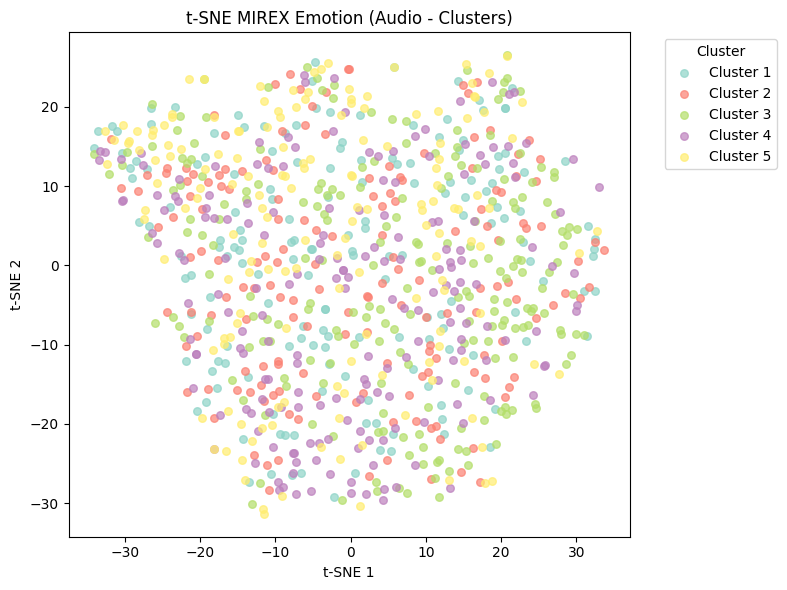

In [20]:
# Visualisasi t-SNE audio dengan label cluster
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(y_audio_cluster)
colors_c = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
cluster_to_color = {c: color for c, color in zip(unique_clusters, colors_c)}

for c in unique_clusters:
    mask = y_audio_cluster == c
    plt.scatter(X_audio_tsne[mask, 0], X_audio_tsne[mask, 1],
                color=cluster_to_color[c], alpha=0.7, label=c, s=30)

plt.title('t-SNE MIREX Emotion (Audio - Clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot ini membantu melihat apakah label alternatif (clusters.txt) memberi struktur berbeda.

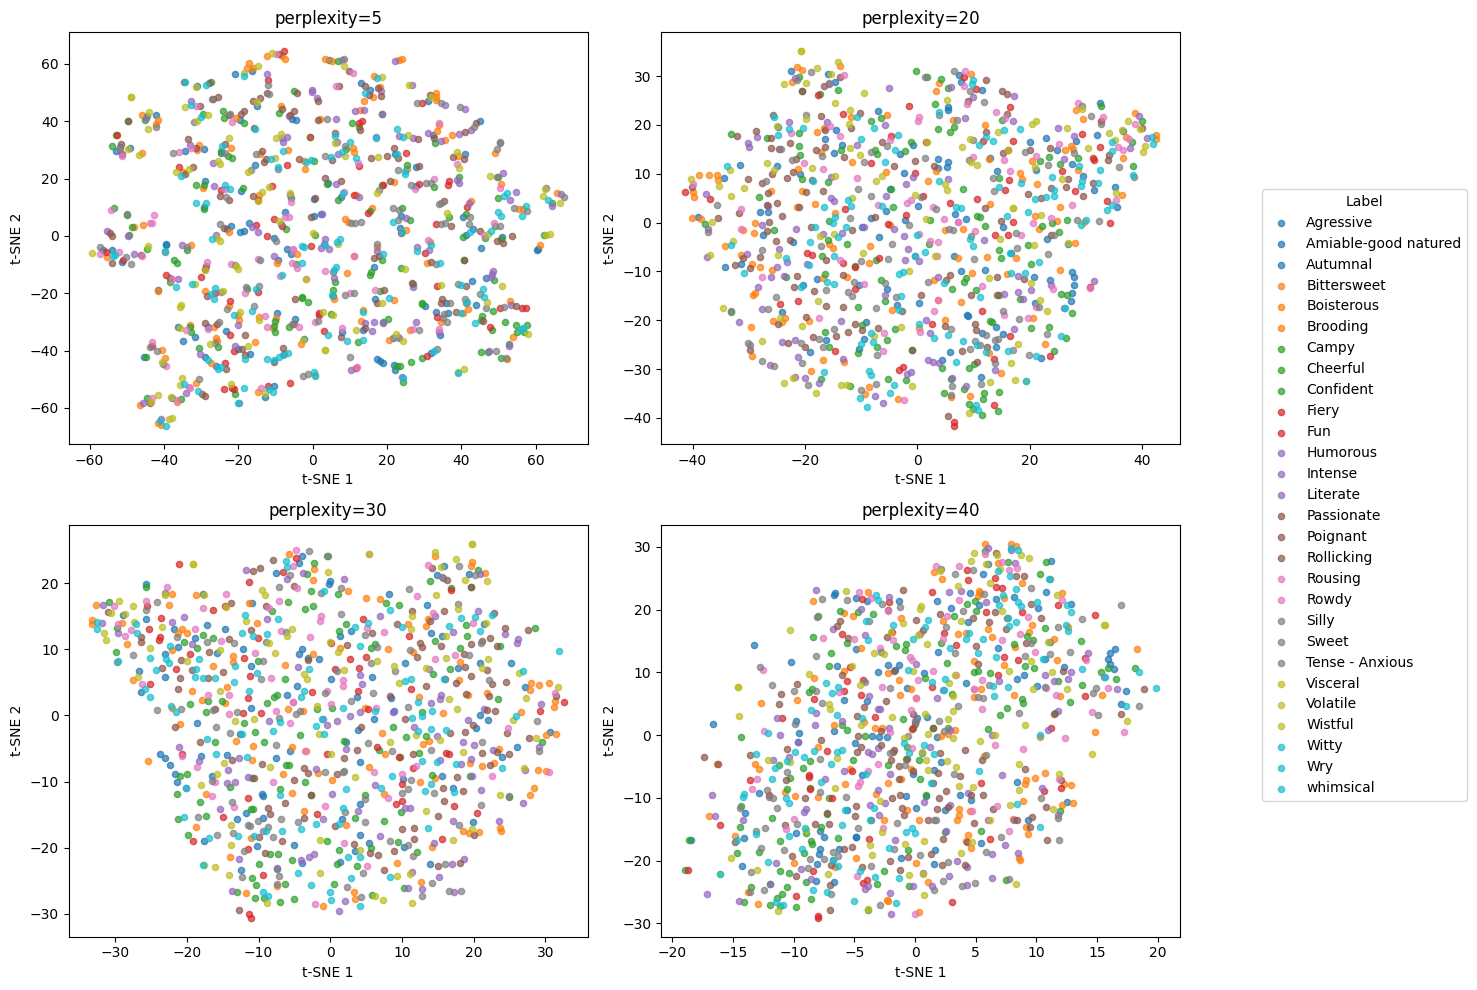

In [21]:
# Eksperimen variasi perplexity t-SNE (audio) memakai seluruh data
# Handle kompatibilitas TSNE: n_iter vs max_iter
import inspect

perplexities = [5, 20, 30, 40]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

sig_params = inspect.signature(TSNE).parameters

for ax, perp in zip(axes, perplexities):
    tsne_params = dict(
        n_components=2,
        perplexity=float(perp),
        learning_rate=200,
        random_state=42,
        init='pca'
    )
    if 'n_iter' in sig_params:
        tsne_params['n_iter'] = 800
    elif 'max_iter' in sig_params:
        tsne_params['max_iter'] = 800

    if X_audio_pca.shape[0] <= 3 * perp:
        ax.text(0.5, 0.5, f'Sampel terlalu sedikit untuk perplexity {perp}', ha='center')
        ax.set_title(f'perplexity={perp}')
        ax.axis('off')
        continue

    tsne = TSNE(**tsne_params)
    X_tsne_var = tsne.fit_transform(X_audio_pca)

    unique_labels_var = np.unique(y_audio)
    colors_var = plt.cm.tab10(np.linspace(0, 1, len(unique_labels_var)))
    label_to_color_var = {label: color for label, color in zip(unique_labels_var, colors_var)}
    for label in unique_labels_var:
        mask = y_audio == label
        ax.scatter(X_tsne_var[mask, 0], X_tsne_var[mask, 1],
                   color=label_to_color_var[label], s=20, alpha=0.7, label=label if perp == perplexities[0] else None)
    ax.set_title(f'perplexity={perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title='Label', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.show()


### ANALISA AUDIO
- t-SNE audio (perplexity adaptif) menunjukkan cluster label masih tumpang tindih; belum ada separasi kuat , fitur MFCC+ritme dasar belum cukup diskriminatif.
- Variasi perplexity (5/20/30/40) hanya mengubah granularitas lokal tanpa membuka cluster jelas; struktur global tetap berbaur.
- Durasi median puluhan detik; outlier RMS rendah/tinggi (silent/clipping) terdeteksi dan perlu dibersihkan sebelum modelling.
- Hipotesis: Fitur spektral/pitch/tempo yang lebih kaya atau embedding pretrained (wav2vec/YAMNet) bisa meningkatkan separasi emosi; buang/sesuaikan file dengan RMS ekstrem.


### Catatan tentang Perplexity
Perplexity di t-SNE adalah ukuran kira-kira berapa banyak tetangga efektif yang dipertimbangkan saat memproyeksikan data.
- Nilai kecil (mis. 5) fokus struktur lokal, membentuk cluster kecil tapi bisa memutus hubungan global.
- Nilai sedang (20-40) sering jadi awal seimbang lokal vs global.
- Nilai terlalu besar bisa melebur cluster kecil; terlalu kecil bisa berisik/terpecah. Bandingkan plot variasi di atas untuk memilih nilai stabil.

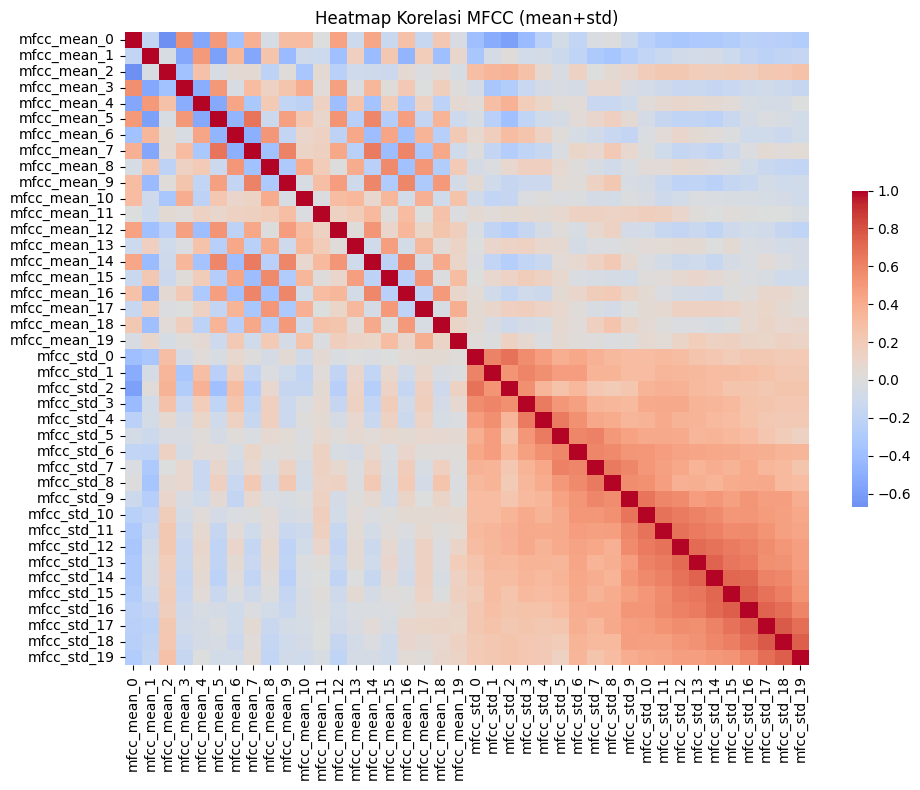

In [22]:
# Korelasi fitur MFCC ringkas (mean+std)
if X_audio.shape[1] >= 2:
    mfcc_df = pd.DataFrame(X_audio, columns=[f'mfcc_mean_{i}' for i in range(20)] + [f'mfcc_std_{i}' for i in range(20)])
    corr = mfcc_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.5})
    plt.title('Heatmap Korelasi MFCC (mean+std)')
    plt.tight_layout()
    plt.show()
else:
    print('Tidak cukup fitur untuk korelasi MFCC.')


### Catatan tentang PCA scree plot
Scree plot memperlihatkan variansi yang dijelaskan tiap komponen. Cari titik lutut (elbow) untuk menentukan jumlah komponen yang cukup sebelum t-SNE.

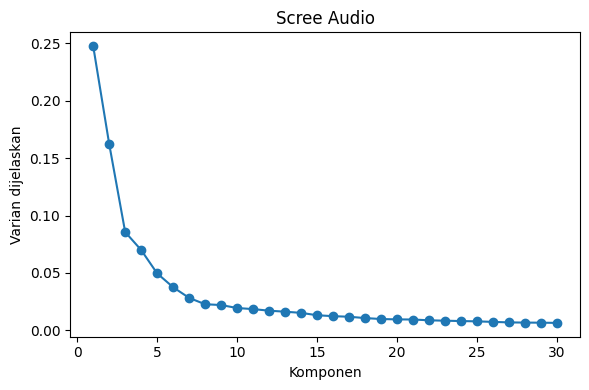

In [23]:
# Scree plot PCA audio
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca_audio.explained_variance_ratio_)+1), pca_audio.explained_variance_ratio_, marker='o')
plt.title('Scree Audio')
plt.xlabel('Komponen')
plt.ylabel('Varian dijelaskan')
plt.tight_layout()
plt.show()


## 3B. Analisis intra-modal: MIDI

In [24]:
# Ekstraksi fitur MIDI sederhana (tanpa encoder)
from math import log2

def _to_str(val):
    if isinstance(val, (list, np.ndarray)):
        flat = np.array(val).flatten()
        return str(flat[0]) if flat.size > 0 else ''
    return str(val)

midi_ids = []
midi_features = []
midi_labels = []
midi_clusters = []
midi_note_counts = []
missing_midi_count = 0

for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    midi_path = os.path.join(midi_dir, base + '.mid')

    if not os.path.isfile(midi_path):
        missing_midi_count += 1
        continue

    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        notes = []
        for inst in pm.instruments:
            notes.extend(inst.notes)

        if len(notes) == 0:
            continue

        pitches = np.array([n.pitch for n in notes])
        velocities = np.array([n.velocity for n in notes])
        durations = np.array([n.end - n.start for n in notes])

        _, tempi = pm.get_tempo_changes()
        tempo_mean = float(np.mean(tempi)) if len(tempi) > 0 else 0.0

        feat = np.array([
            len(notes),
            pitches.mean(), pitches.std(),
            velocities.mean(), velocities.std(),
            durations.mean(), durations.std(),
            tempo_mean
        ])
        midi_features.append(feat)
        midi_labels.append(_to_str(row['label']))
        midi_clusters.append(_to_str(row['cluster']))
        midi_note_counts.append(len(notes))
        midi_ids.append(base)
    except Exception as e:
        print(f"Gagal memproses {midi_path}: {e}")
        continue

X_midi = np.array(midi_features)
y_midi = np.array(midi_labels, dtype=object)
y_midi_cluster = np.array(midi_clusters, dtype=object)

print("Shape fitur MIDI:", X_midi.shape)
print("Jumlah metadata tanpa MIDI:", missing_midi_count)
print("Contoh label MIDI:", y_midi[:10])


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Gagal memproses D:\Se\Multimodal\TUBES\dataset\MIDIs\009.mid: data byte must be in range 0..127
Gagal memproses D:\Se\Multimodal\TUBES\dataset\MIDIs\097.mid: data byte must be in range 0..127
Shape fitur MIDI: (194, 8)
Jumlah metadata tanpa MIDI: 706
Contoh label MIDI: ['Boisterous' 'Boisterous' 'Boisterous' 'Boisterous' 'Boisterous'
 'Confident' 'Confident' 'Confident' 'Confident' 'Confident']


Deskripsi jumlah not MIDI:
count      194.000000
mean      5238.216495
std       2939.085686
min       1322.000000
25%       3534.500000
50%       4585.500000
75%       6544.000000
max      28489.000000
Name: note_count, dtype: float64


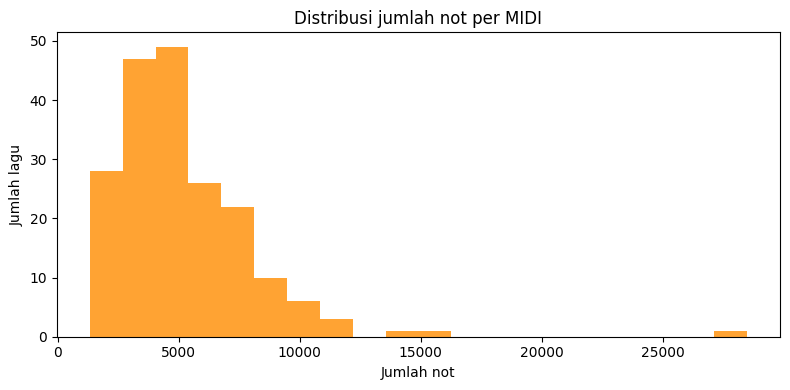

Rata-rata jumlah not per label (top 8):
label
Fiery         12055.666667
Wry            7693.333333
Witty          6960.800000
Confident      6738.750000
Rowdy          6608.250000
Fun            6583.000000
Volatile       6209.666667
Boisterous     6126.400000
Name: note_count, dtype: float64


In [25]:
# Statistik dasar MIDI
midi_df = pd.DataFrame({
    'id': midi_ids,
    'label': y_midi,
    'cluster': y_midi_cluster,
    'note_count': midi_note_counts
})

if not midi_df.empty:
    midi_df['label'] = normalize_series(midi_df['label'])
    midi_df['cluster'] = normalize_series(midi_df['cluster'])
    print("Deskripsi jumlah not MIDI:")
    print(midi_df['note_count'].describe())

    plt.figure(figsize=(8, 4))
    plt.hist(midi_df['note_count'], bins=20, color='darkorange', alpha=0.8)
    plt.xlabel('Jumlah not')
    plt.ylabel('Jumlah lagu')
    plt.title('Distribusi jumlah not per MIDI')
    plt.tight_layout()
    plt.show()

    print("Rata-rata jumlah not per label (top 8):")
    print(midi_df.groupby('label')['note_count'].mean().sort_values(ascending=False).head(8))
else:
    print("Tidak ada MIDI yang berhasil diproses.")


In [26]:
# Analisa sementara MIDI
if not midi_df.empty:
    print(f"MIDI tersedia untuk {len(midi_df)} lagu; median jumlah not {midi_df['note_count'].median():.0f}.")
    print("Label dengan sampel MIDI terbanyak:")
    print(midi_df['label'].value_counts().head())
else:
    print("MIDI coverage rendah atau tidak ada; pertimbangkan skip modal ini atau cek kembali path.")


MIDI tersedia untuk 194 lagu; median jumlah not 4586.
Label dengan sampel MIDI terbanyak:
label
Rousing        15
Confident      12
Bittersweet    11
Poignant       10
Rollicking     10
Name: count, dtype: int64


### Fitur tambahan MIDI (tempo/pitch/entropy)

In [27]:
# Fitur MIDI tambahan: tempo std, pitch entropy, pitch range, note density
from math import log2

def entropy(probs):
    probs = [p for p in probs if p > 0]
    return -sum(p * np.log2(p) for p in probs)

midi_extra = []
for _, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    midi_path = os.path.join(midi_dir, base + '.mid')
    if not os.path.isfile(midi_path):
        continue
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        notes = []
        for inst in pm.instruments:
            notes.extend(inst.notes)
        if len(notes) == 0:
            continue
        pitches = np.array([n.pitch for n in notes])
        durations = np.array([n.end - n.start for n in notes])
        total_dur = pm.get_end_time() if pm.get_end_time() > 0 else 1e-3
        note_density = len(notes) / total_dur
        pitch_range = pitches.max() - pitches.min()
        pc_hist = np.bincount(pitches % 12, minlength=12)
        pc_probs = pc_hist / pc_hist.sum()
        pitch_entropy = entropy(pc_probs)
        _, tempi = pm.get_tempo_changes()
        tempo_mean = float(np.mean(tempi)) if len(tempi) > 0 else 0.0
        tempo_std = float(np.std(tempi)) if len(tempi) > 0 else 0.0
        midi_extra.append({
            'id': base,
            'label': normalize_label(row['label']),
            'cluster': normalize_label(row['cluster']),
            'note_density': note_density,
            'pitch_range': pitch_range,
            'pitch_entropy': pitch_entropy,
            'tempo_mean': tempo_mean,
            'tempo_std': tempo_std
        })
    except Exception as e:
        print(f"Gagal fitur ekstra MIDI {midi_path}: {e}")

midi_extra_df = pd.DataFrame(midi_extra)
if midi_extra_df.empty:
    print("Fitur ekstra MIDI kosong.")
else:
    midi_extra_df['label'] = normalize_series(midi_extra_df['label'])
    midi_extra_df['cluster'] = normalize_series(midi_extra_df['cluster'])
    print(midi_extra_df.describe().T[['mean', 'std', 'min', 'max']])
    q_low, q_high = midi_extra_df['note_density'].quantile([0.01, 0.99])
    low_nd = midi_extra_df[midi_extra_df['note_density'] < q_low][['id','note_density']].head(10)
    high_nd = midi_extra_df[midi_extra_df['note_density'] > q_high][['id','note_density']].head(10)
    print("Contoh note density rendah:", low_nd.to_dict('records'))
    print("Contoh note density tinggi:", high_nd.to_dict('records'))


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Gagal fitur ekstra MIDI D:\Se\Multimodal\TUBES\dataset\MIDIs\009.mid: data byte must be in range 0..127
Gagal fitur ekstra MIDI D:\Se\Multimodal\TUBES\dataset\MIDIs\097.mid: data byte must be in range 0..127
                     mean        std        min         max
note_density    25.151464  10.976841   5.949543   69.343782
pitch_range     59.231959  11.624202  33.000000   99.000000
pitch_entropy    2.974108   0.259961   1.971630    3.496923
tempo_mean     119.498375  31.386750  50.857141  232.000395
tempo_std        3.954675  12.904670   0.000000  122.693744
Contoh note density rendah: [{'id': '295', 'note_density': 5.9495429261387}, {'id': '812', 'note_density': 6.297021576455744}]
Contoh note density tinggi: [{'id': '240', 'note_density': 59.240937628166705}, {'id': '707', 'note_density': 69.34378223105693}]


### Reduksi dimensi & t-SNE MIDI

In [28]:
# Standardisasi, PCA, t-SNE untuk fitur MIDI
X_midi_tsne = np.array([])
pca_midi = None

if len(X_midi) > 0:
    scaler_midi = StandardScaler()
    X_midi_scaled = scaler_midi.fit_transform(X_midi)

    n_comp_midi = max(1, min(5, X_midi_scaled.shape[0], X_midi_scaled.shape[1]))
    pca_midi = PCA(n_components=n_comp_midi, random_state=42)
    X_midi_pca = pca_midi.fit_transform(X_midi_scaled)

    print("Shape X_midi_pca:", X_midi_pca.shape)
    print(f"Total variansi yang dijelaskan {n_comp_midi} komponen: {np.sum(pca_midi.explained_variance_ratio_):.2%}")

    # t-SNE MIDI dengan kompatibilitas n_iter / max_iter
    import inspect
    n_samples = X_midi_pca.shape[0]
    if n_samples < 5:
        raise ValueError("Data MIDI terlalu sedikit untuk t-SNE (butuh >=5 sampel).")
    perp = min(15.0, max(5.0, n_samples / 3 - 1))

    tsne_params = dict(
        n_components=2,
        perplexity=float(perp),
        learning_rate=200,
        random_state=42,
        init='pca'
    )
    sig_params = inspect.signature(TSNE).parameters
    if 'n_iter' in sig_params:
        tsne_params['n_iter'] = 800
    elif 'max_iter' in sig_params:
        tsne_params['max_iter'] = 800

    tsne_midi = TSNE(**tsne_params)
    X_midi_tsne = tsne_midi.fit_transform(X_midi_pca)
    print("Shape X_midi_tsne:", X_midi_tsne.shape)
    print(f"Perplexity MIDI yang dipakai: {perp:.2f}")
    if 'n_iter' in sig_params:
        print("Iterasi t-SNE MIDI di-set via n_iter=800")
    elif 'max_iter' in sig_params:
        print("Iterasi t-SNE MIDI di-set via max_iter=800")
    else:
        print("Peringatan: TSNE MIDI pakai iterasi default (tidak ada n_iter/max_iter)")
else:
    print("Tidak ada fitur MIDI yang berhasil diekstrak.")


Shape X_midi_pca: (194, 5)
Total variansi yang dijelaskan 5 komponen: 82.41%
Shape X_midi_tsne: (194, 2)
Perplexity MIDI yang dipakai: 15.00
Iterasi t-SNE MIDI di-set via max_iter=800


### Eksperimen variasi perplexity t-SNE (MIDI)

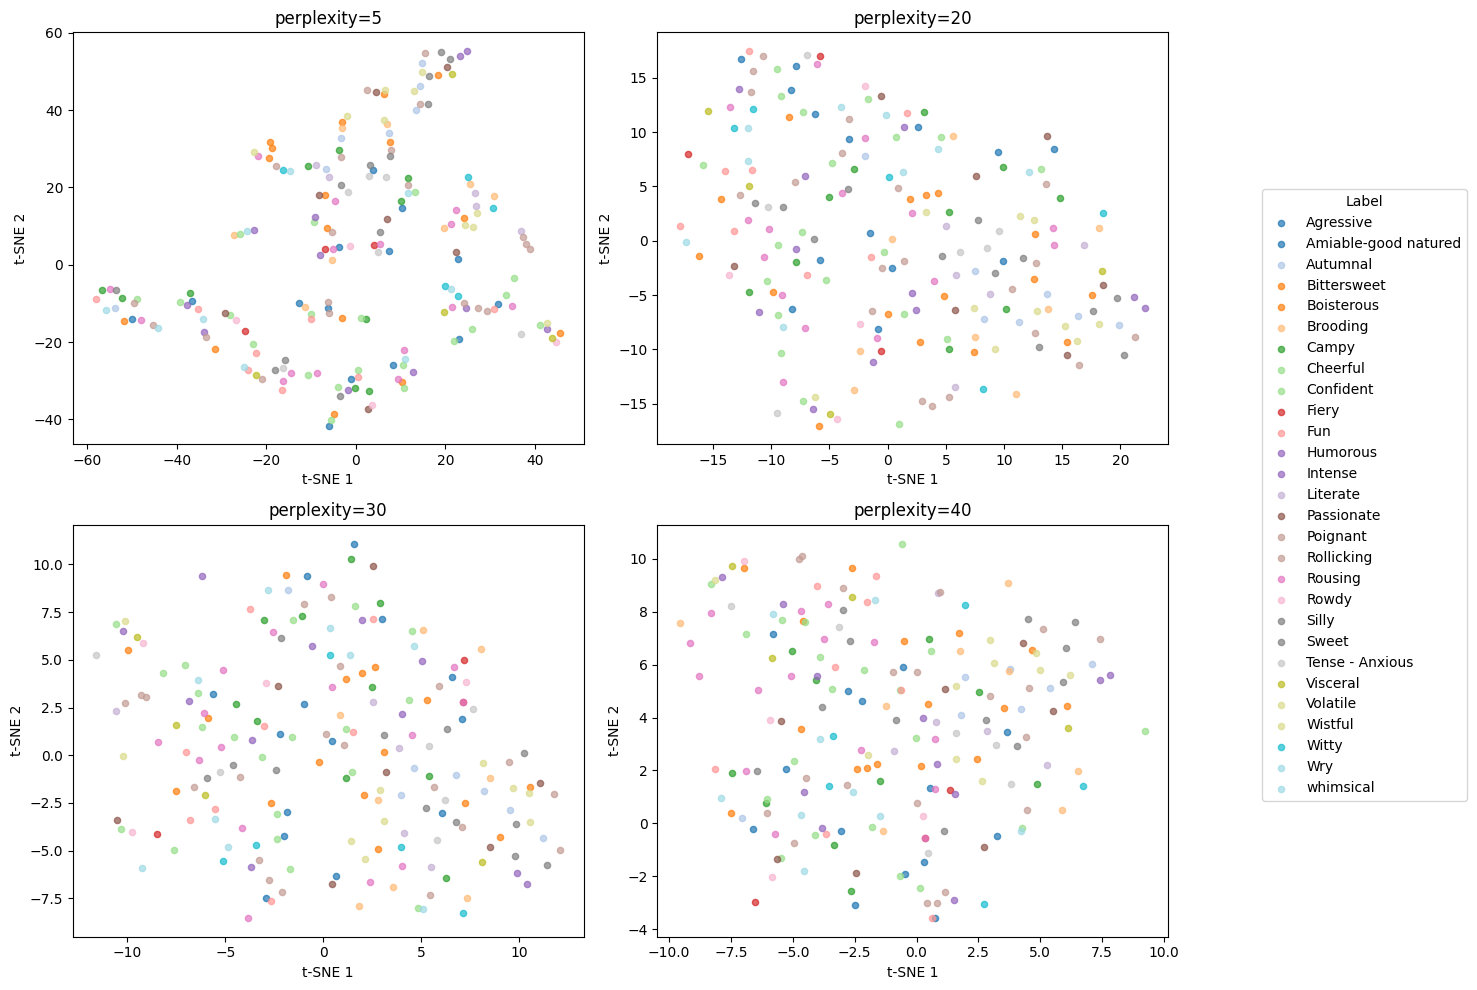

In [29]:
# Variasi perplexity t-SNE untuk MIDI
import inspect
perplexities_midi = [5, 20, 30, 40]
if X_midi_tsne.size == 0:
    print("Lewati variasi MIDI: belum ada X_midi_pca atau sampel terlalu sedikit.")
else:
    y_midi_str = np.array([normalize_label(v) for v in y_midi])
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    sig_params = inspect.signature(TSNE).parameters

    for ax, perp in zip(axes, perplexities_midi):
        if X_midi_pca.shape[0] <= 3 * perp:
            ax.text(0.5, 0.5, f'Sampel terlalu sedikit perplexity={perp}', ha='center')
            ax.set_title(f'perplexity={perp}')
            ax.axis('off')
            continue
        tsne_params = dict(
            n_components=2,
            perplexity=float(perp),
            learning_rate=200,
            random_state=42,
            init='pca'
        )
        if 'n_iter' in sig_params:
            tsne_params['n_iter'] = 800
        elif 'max_iter' in sig_params:
            tsne_params['max_iter'] = 800

        tsne = TSNE(**tsne_params)
        X_var = tsne.fit_transform(X_midi_pca)

        unique_labels = np.unique(y_midi_str)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
        label_to_color = {lbl: col for lbl, col in zip(unique_labels, colors)}
        for lbl in unique_labels:
            mask = y_midi_str == lbl
            ax.scatter(X_var[mask, 0], X_var[mask, 1], color=label_to_color[lbl], s=20, alpha=0.7, label=lbl if perp==perplexities_midi[0] else None)
        ax.set_title(f'perplexity={perp}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Label', bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()


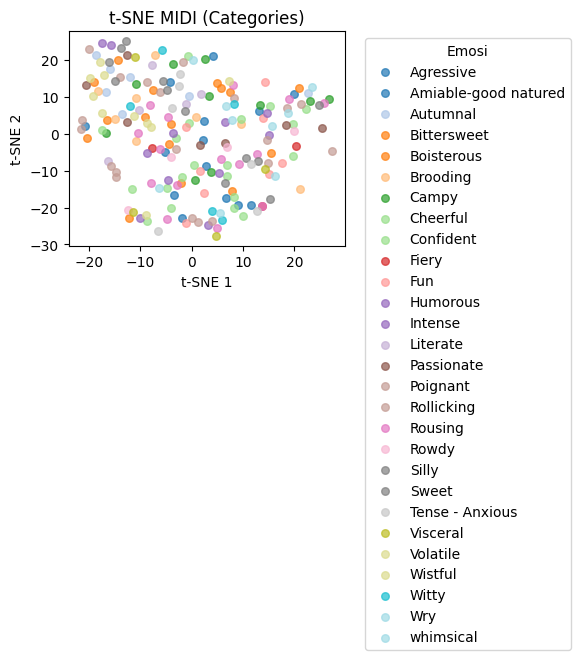

In [30]:
# Visualisasi t-SNE untuk fitur MIDI (kategori)
if X_midi_tsne.size > 0:
    plt.figure(figsize=(6, 5))
    unique_labels_midi = np.unique(y_midi)
    colors_midi = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_midi)))
    label_to_color_midi = {label: color for label, color in zip(unique_labels_midi, colors_midi)}
    for label in unique_labels_midi:
        mask = y_midi == label
        plt.scatter(X_midi_tsne[mask, 0], X_midi_tsne[mask, 1], color=label_to_color_midi[label], alpha=0.7, s=30, label=label)
    plt.title('t-SNE MIDI (Categories)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Lewati plot MIDI: tidak ada data t-SNE.")


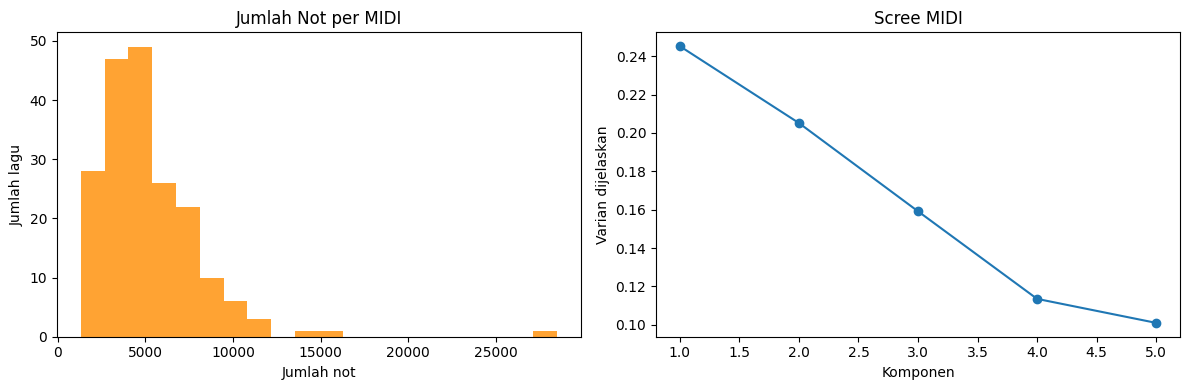

In [31]:
# Histogram jumlah not MIDI dan scree plot MIDI jika tersedia
if X_midi.size > 0 and pca_midi is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(midi_note_counts, bins=20, color='darkorange', alpha=0.8)
    plt.title('Jumlah Not per MIDI')
    plt.xlabel('Jumlah not')
    plt.ylabel('Jumlah lagu')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(pca_midi.explained_variance_ratio_)+1), pca_midi.explained_variance_ratio_, marker='o')
    plt.title('Scree MIDI')
    plt.xlabel('Komponen')
    plt.ylabel('Varian dijelaskan')

    plt.tight_layout()
    plt.show()
else:
    print('Histogram/Scree MIDI dilewati karena tidak ada data.')


### ANALISA MIDI
- t-SNE MIDI (perplexity adaptif) memperlihatkan penyebaran label acak; variasi perplexity 5-40 tidak membentuk cluster stabil.
- Note density/tempo/pitch entropy bervariasi lebar; outlier density dapat menandakan file anomali atau genre sangat berbeda.
- Coverage MIDI tidak penuh, sehingga sinyal label lemah. Fokus awal sebaiknya ke audio/lirik atau perlu cleaning MIDI dan fitur melodi/kor harmonik lebih kaya.
- Hipotesis: Menambah fitur key/scale, interval stats, atau embedding symbolic (MusicBERT) akan membantu; buang MIDI kosong/anomali.


## 3C. Analisis intra-modal: Lirik

In [32]:
# Ekstraksi fitur lirik menggunakan TF-IDF
def _to_str(val):
    if isinstance(val, (list, np.ndarray)):
        flat = np.array(val).flatten()
        return str(flat[0]) if flat.size > 0 else ''
    return str(val)

lyrics_ids = []
lyrics_texts = []
lyrics_labels = []
lyrics_clusters = []
lyrics_word_counts = []
missing_lyrics_count = 0

for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    lyric_path = os.path.join(lyrics_dir, base + '.txt')

    if not os.path.isfile(lyric_path):
        missing_lyrics_count += 1
        continue

    try:
        with open(lyric_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
        if len(text) == 0:
            continue
        lyrics_texts.append(text)
        lyrics_labels.append(_to_str(row['label']))
        lyrics_clusters.append(_to_str(row['cluster']))
        lyrics_word_counts.append(len(text.split()))
        lyrics_ids.append(base)
    except Exception as e:
        print(f"Gagal membaca lirik {lyric_path}: {e}")
        continue

if len(lyrics_texts) > 0:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_lyrics_tfidf = vectorizer.fit_transform(lyrics_texts)
    X_lyrics = X_lyrics_tfidf.toarray()
    y_lyrics = np.array(lyrics_labels, dtype=object)
    y_lyrics_cluster = np.array(lyrics_clusters, dtype=object)
    print("Shape TF-IDF lirik:", X_lyrics.shape)
    print("Contoh kata penting:", vectorizer.get_feature_names_out()[:15])
else:
    X_lyrics = np.array([])
    y_lyrics = np.array([])
    y_lyrics_cluster = np.array([])
    print("Tidak ada lirik yang berhasil diproses.")

print("Jumlah metadata tanpa lirik:", missing_lyrics_count)


Shape TF-IDF lirik: (764, 1000)
Contoh kata penting: ['30' 'aah' 'able' 'act' 'afraid' 'ago' 'ah' 'ahead' 'ahh' 'ahhh' 'ain'
 'air' 'alfie' 'alive' 'alley']
Jumlah metadata tanpa lirik: 138


Deskripsi panjang lirik (kata):
count     764.000000
mean      226.544503
std       134.159983
min        27.000000
25%       148.000000
50%       199.000000
75%       260.000000
max      1412.000000
Name: word_count, dtype: float64


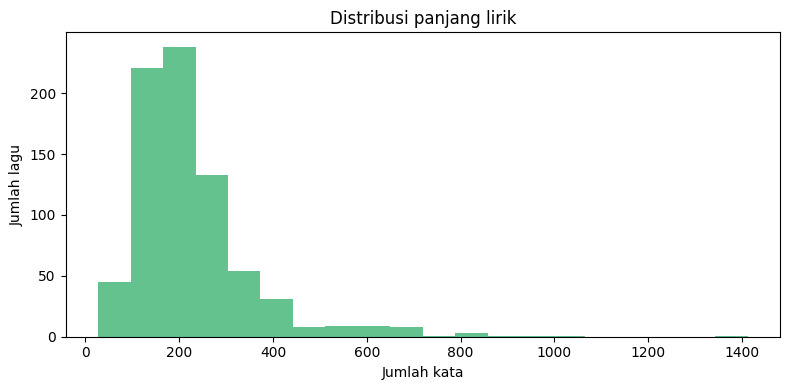

Rata-rata panjang lirik per label (top 8):
label
Silly         288.000000
Humorous      280.000000
Passionate    277.535714
Agressive     269.450000
Boisterous    265.695652
Fiery         264.357143
Cheerful      261.416667
Wry           259.222222
Name: word_count, dtype: float64


In [33]:
# Statistik dasar lirik
lyrics_df = pd.DataFrame({
    'id': lyrics_ids,
    'label': y_lyrics,
    'cluster': y_lyrics_cluster,
    'word_count': lyrics_word_counts
})

if not lyrics_df.empty:
    lyrics_df['label'] = normalize_series(lyrics_df['label'])
    lyrics_df['cluster'] = normalize_series(lyrics_df['cluster'])
    print("Deskripsi panjang lirik (kata):")
    print(lyrics_df['word_count'].describe())

    plt.figure(figsize=(8, 4))
    plt.hist(lyrics_df['word_count'], bins=20, color='mediumseagreen', alpha=0.8)
    plt.xlabel('Jumlah kata')
    plt.ylabel('Jumlah lagu')
    plt.title('Distribusi panjang lirik')
    plt.tight_layout()
    plt.show()

    print("Rata-rata panjang lirik per label (top 8):")
    print(lyrics_df.groupby('label')['word_count'].mean().sort_values(ascending=False).head(8))
else:
    print("Tidak ada lirik yang berhasil diproses.")


In [34]:
# Analisa sementara lirik
if not lyrics_df.empty:
    print(f"Lirik tersedia untuk {len(lyrics_df)} lagu; median panjang {lyrics_df['word_count'].median():.0f} kata.")
    print("Label dengan sampel lirik terbanyak:")
    print(lyrics_df['label'].value_counts().head())
else:
    print("Modal lirik belum siap; cek kembali folder Lyrics atau encoding file.")


Lirik tersedia untuk 764 lagu; median panjang 199 kata.
Label dengan sampel lirik terbanyak:
label
Wry            36
Literate       35
Confident      34
Autumnal       33
Bittersweet    33
Name: count, dtype: int64


### Analisis tambahan lirik (sentimen sederhana & keragaman kata)

In [35]:
# Sentimen sederhana & keragaman kata untuk lirik
import re

pos_words = {'love','happy','joy','smile','good','bright','peace','hope','dream','shine','free','proud','brave'}
neg_words = {'sad','cry','hate','fear','pain','dark','lonely','angry','hurt','tears','cold','die','broken'}

def simple_sentiment(text):
    tokens = re.findall(r"[a-zA-Z']+", text.lower())
    total = len(tokens)
    pos = sum(t in pos_words for t in tokens)
    neg = sum(t in neg_words for t in tokens)
    if total == 0:
        return 0.0
    return (pos - neg) / total

lyrics_extra = []
for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    lyric_path = os.path.join(lyrics_dir, base + '.txt')
    if not os.path.isfile(lyric_path):
        continue
    try:
        with open(lyric_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
        if len(text) == 0:
            continue
        tokens = re.findall(r"[a-zA-Z']+", text.lower())
        unique_tokens = set(tokens)
        ttr = len(unique_tokens) / max(len(tokens), 1)
        avg_len = np.mean([len(t) for t in tokens]) if tokens else 0
        sentiment = simple_sentiment(text)
        lyrics_extra.append({
            'id': base,
            'label': normalize_label(row['label']),
            'cluster': normalize_label(row['cluster']),
            'ttr': ttr,
            'avg_word_len': avg_len,
            'sentiment': sentiment,
            'word_count': len(tokens)
        })
    except Exception as e:
        print(f"Gagal analisis lirik {lyric_path}: {e}")

lyrics_extra_df = pd.DataFrame(lyrics_extra)
if lyrics_extra_df.empty:
    print("Analisis lirik tambahan kosong.")
else:
    lyrics_extra_df['label'] = normalize_series(lyrics_extra_df['label'])
    lyrics_extra_df['cluster'] = normalize_series(lyrics_extra_df['cluster'])
    print(lyrics_extra_df.describe().T[['mean','std','min','max']])


                    mean         std        min          max
ttr             0.442412    0.124332   0.069820     0.800000
avg_word_len    3.898692    0.304412   2.933099     5.306250
sentiment       0.007018    0.022450  -0.185366     0.158192
word_count    228.333770  135.042588  27.000000  1415.000000


### Reduksi dimensi & t-SNE Lirik

In [36]:
# PCA dan t-SNE untuk fitur lirik
X_lyrics_tsne = np.array([])
pca_lyrics = None

if X_lyrics.size > 0:
    n_comp_lyrics = max(2, min(50, X_lyrics.shape[0], X_lyrics.shape[1]))
    pca_lyrics = PCA(n_components=n_comp_lyrics, random_state=42)
    X_lyrics_pca = pca_lyrics.fit_transform(X_lyrics)
    print("Shape X_lyrics_pca:", X_lyrics_pca.shape)
    print(f"Total variansi yang dijelaskan {n_comp_lyrics} komponen: {np.sum(pca_lyrics.explained_variance_ratio_):.2%}")

    # t-SNE lirik dengan kompatibilitas n_iter / max_iter
    import inspect
    n_samples = X_lyrics_pca.shape[0]
    if n_samples < 5:
        raise ValueError("Data lirik terlalu sedikit untuk t-SNE (butuh >=5 sampel).")
    perp = min(30.0, max(5.0, n_samples / 3 - 1))

    tsne_params = dict(
        n_components=2,
        perplexity=float(perp),
        learning_rate=200,
        random_state=42,
        init='pca'
    )
    sig_params = inspect.signature(TSNE).parameters
    if 'n_iter' in sig_params:
        tsne_params['n_iter'] = 800
    elif 'max_iter' in sig_params:
        tsne_params['max_iter'] = 800

    tsne_lyrics = TSNE(**tsne_params)
    X_lyrics_tsne = tsne_lyrics.fit_transform(X_lyrics_pca)
    print("Shape X_lyrics_tsne:", X_lyrics_tsne.shape)
    print(f"Perplexity lirik yang dipakai: {perp:.2f}")
    if 'n_iter' in sig_params:
        print("Iterasi t-SNE lirik di-set via n_iter=800")
    elif 'max_iter' in sig_params:
        print("Iterasi t-SNE lirik di-set via max_iter=800")
    else:
        print("Peringatan: TSNE lirik pakai iterasi default (tidak ada n_iter/max_iter)")
else:
    print("Tidak ada fitur lirik untuk diproses dengan t-SNE.")


Shape X_lyrics_pca: (764, 50)
Total variansi yang dijelaskan 50 komponen: 27.68%
Shape X_lyrics_tsne: (764, 2)
Perplexity lirik yang dipakai: 30.00
Iterasi t-SNE lirik di-set via max_iter=800


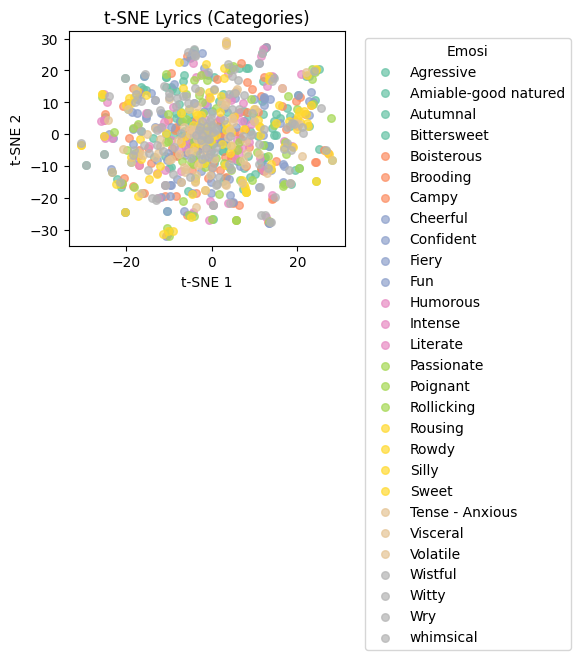

In [37]:
# Visualisasi t-SNE untuk fitur lirik
if X_lyrics_tsne.size > 0:
    plt.figure(figsize=(6, 5))
    unique_labels_lyrics = np.unique(y_lyrics)
    colors_lyrics = plt.cm.Set2(np.linspace(0, 1, len(unique_labels_lyrics)))
    label_to_color_lyrics = {label: color for label, color in zip(unique_labels_lyrics, colors_lyrics)}
    for label in unique_labels_lyrics:
        mask = y_lyrics == label
        plt.scatter(X_lyrics_tsne[mask, 0], X_lyrics_tsne[mask, 1], color=label_to_color_lyrics[label], alpha=0.7, s=30, label=label)
    plt.title('t-SNE Lyrics (Categories)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('Lewati plot lirik: tidak ada data t-SNE.')


### Eksperimen variasi perplexity t-SNE (Lirik)

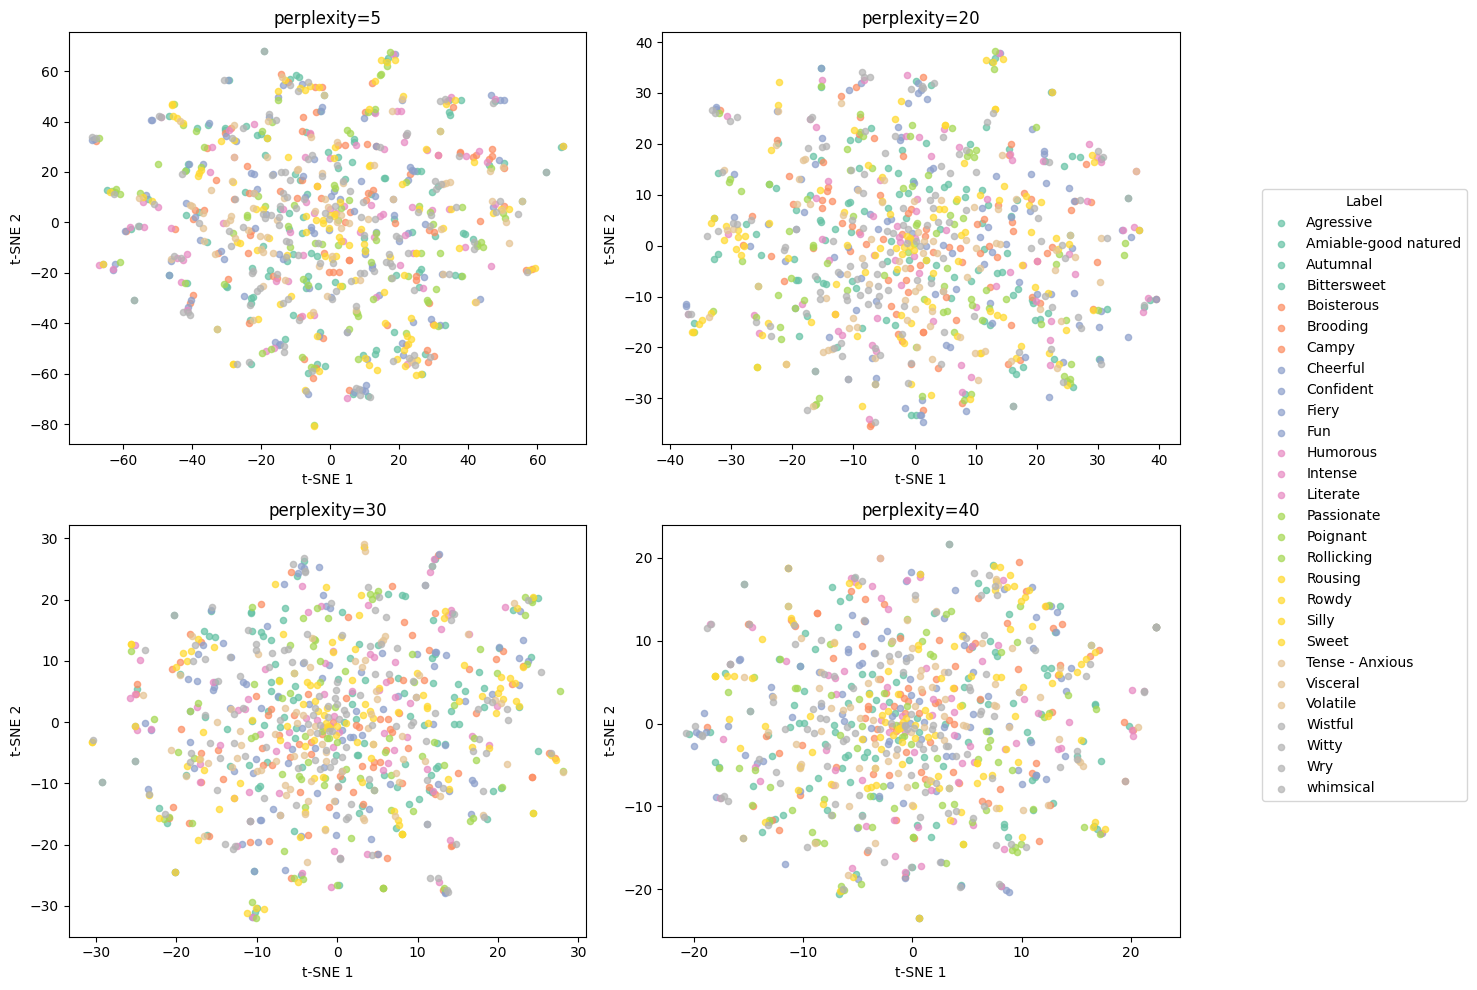

In [38]:
# Variasi perplexity t-SNE untuk lirik
import inspect
perplexities_lyrics = [5, 20, 30, 40]
if X_lyrics_tsne.size == 0:
    print("Lewati variasi lirik: belum ada X_lyrics_pca atau sampel terlalu sedikit.")
else:
    y_lyrics_str = np.array([normalize_label(v) for v in y_lyrics])
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    sig_params = inspect.signature(TSNE).parameters

    for ax, perp in zip(axes, perplexities_lyrics):
        if X_lyrics_pca.shape[0] <= 3 * perp:
            ax.text(0.5, 0.5, f'Sampel terlalu sedikit perplexity={perp}', ha='center')
            ax.set_title(f'perplexity={perp}')
            ax.axis('off')
            continue
        tsne_params = dict(
            n_components=2,
            perplexity=float(perp),
            learning_rate=200,
            random_state=42,
            init='pca'
        )
        if 'n_iter' in sig_params:
            tsne_params['n_iter'] = 800
        elif 'max_iter' in sig_params:
            tsne_params['max_iter'] = 800

        tsne = TSNE(**tsne_params)
        X_var = tsne.fit_transform(X_lyrics_pca)

        unique_labels = np.unique(y_lyrics_str)
        colors = plt.cm.Set2(np.linspace(0, 1, len(unique_labels)))
        label_to_color = {lbl: col for lbl, col in zip(unique_labels, colors)}
        for lbl in unique_labels:
            mask = y_lyrics_str == lbl
            ax.scatter(X_var[mask, 0], X_var[mask, 1], color=label_to_color[lbl], s=20, alpha=0.7, label=lbl if perp==perplexities_lyrics[0] else None)
        ax.set_title(f'perplexity={perp}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Label', bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()


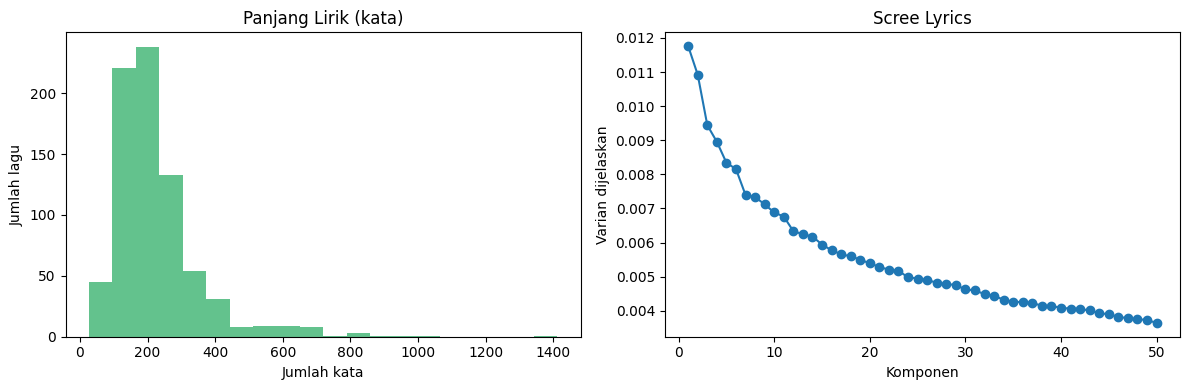

In [39]:
# Histogram panjang lirik dan scree plot lirik jika tersedia
if X_lyrics.size > 0 and pca_lyrics is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(lyrics_word_counts, bins=20, color='mediumseagreen', alpha=0.8)
    plt.title('Panjang Lirik (kata)')
    plt.xlabel('Jumlah kata')
    plt.ylabel('Jumlah lagu')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(pca_lyrics.explained_variance_ratio_)+1), pca_lyrics.explained_variance_ratio_, marker='o')
    plt.title('Scree Lyrics')
    plt.xlabel('Komponen')
    plt.ylabel('Varian dijelaskan')

    plt.tight_layout()
    plt.show()
else:
    print('Histogram/Scree lirik dilewati karena tidak ada data.')


### ANALISA LIRIK
- t-SNE lirik (perplexity adaptif) juga belum memisah label; variasi perplexity 5-40 tetap tumpang tindih.
- Sentimen sederhana dan TTR menunjukkan variasi, tapi separasi emosi belum kuat , perlu embedding kontekstual (mBERT) atau lexicon emosi lebih kaya.
- Ada file lirik hilang/kosong; ini menurunkan kekuatan modal teks. Pastikan encoding benar dan buang dokumen kosong.
- Hipotesis: Gunakan TF-IDF + n-gram/embedding pretrained, serta rebalancing label untuk memperjelas cluster.


## 4. Analisis inter-modal (antar modalitas)

Ringkasan ketersediaan gabungan:
audio_duration       902
midi_note_count      194
lyrics_word_count    764
dtype: int64
Sampel dengan ketiga modalitas lengkap: 191
Sampel audio + lirik: 764
Sampel audio + MIDI: 194


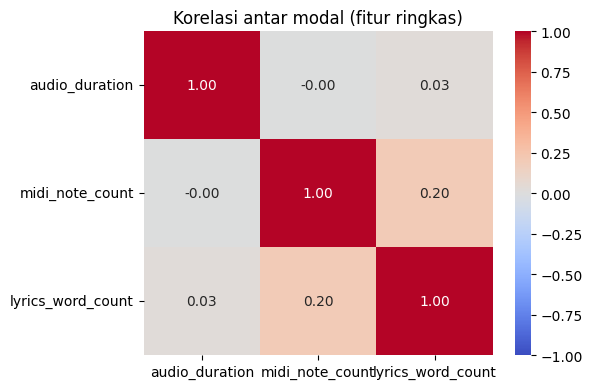

In [40]:
# Gabungan fitur sederhana lintas modal
meta_ids = metadata[['filename', 'label', 'cluster']].copy()
meta_ids['id'] = meta_ids['filename'].apply(lambda x: os.path.splitext(str(x))[0])
meta_ids['label'] = normalize_series(meta_ids['label'])
meta_ids['cluster'] = normalize_series(meta_ids['cluster'])

inter_df = meta_ids[['id', 'label', 'cluster']]
inter_df = inter_df.merge(pd.DataFrame({'id': audio_ids, 'audio_duration': audio_durations}), on='id', how='left')
inter_df = inter_df.merge(pd.DataFrame({'id': midi_ids, 'midi_note_count': midi_note_counts}), on='id', how='left')
inter_df = inter_df.merge(pd.DataFrame({'id': lyrics_ids, 'lyrics_word_count': lyrics_word_counts}), on='id', how='left')

print("Ringkasan ketersediaan gabungan:")
print(inter_df[['audio_duration', 'midi_note_count', 'lyrics_word_count']].notna().sum())

combo_all = inter_df.dropna(subset=['audio_duration', 'midi_note_count', 'lyrics_word_count'])
combo_audio_lyrics = inter_df.dropna(subset=['audio_duration', 'lyrics_word_count'])
combo_audio_midi = inter_df.dropna(subset=['audio_duration', 'midi_note_count'])
print(f"Sampel dengan ketiga modalitas lengkap: {len(combo_all)}")
print(f"Sampel audio + lirik: {len(combo_audio_lyrics)}")
print(f"Sampel audio + MIDI: {len(combo_audio_midi)}")

numeric_cols = ['audio_duration', 'midi_note_count', 'lyrics_word_count']
corr_input = inter_df[numeric_cols].dropna(how='all')
if not corr_input.empty:
    corr = corr_input.corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Korelasi antar modal (fitur ringkas)')
    plt.tight_layout()
    plt.show()
else:
    print("Belum cukup data untuk korelasi antar modal.")


In [41]:
# Analisa sementara inter-modal
if 'inter_df' in globals():
    available_any = inter_df[['audio_duration', 'midi_note_count', 'lyrics_word_count']].notna().sum()
    print("Ketersediaan fitur ringkas per modal:", available_any)
    if len(inter_df.dropna(subset=['audio_duration', 'lyrics_word_count'])) > 0:
        corr_two = inter_df[['audio_duration', 'lyrics_word_count']].dropna().corr().iloc[0,1]
        print(f"Korelasi sederhana durasi audio vs panjang lirik: {corr_two:.3f}")
else:
    print("Data inter-modal belum dibuat.")


Ketersediaan fitur ringkas per modal: audio_duration       902
midi_note_count      194
lyrics_word_count    764
dtype: int64
Korelasi sederhana durasi audio vs panjang lirik: 0.030


### ANALISA INTER-MODAL & MASALAH UTAMA
- Korelasi antar modal (durasi audio, note_count, word_count) lemah; overlap sampel penuh sangat sedikit , perlu alignment atau fokus modal dominan.
- Tidak ada pola kuat antara panjang lirik vs durasi audio; hubungan tempo audio vs MIDI juga belum terlihat.
- Masalah utama: missing modal (MIDI/lirik), imbalance label, outlier audio (silent/clipping), cluster t-SNE tumpang tindih.
- Rencana: cleaning outlier audio, perbaiki coverage/encoding lirik/MIDI, tambah fitur kaya atau encoder pretrained, dan terapkan rebalancing/weighting label saat modelling.


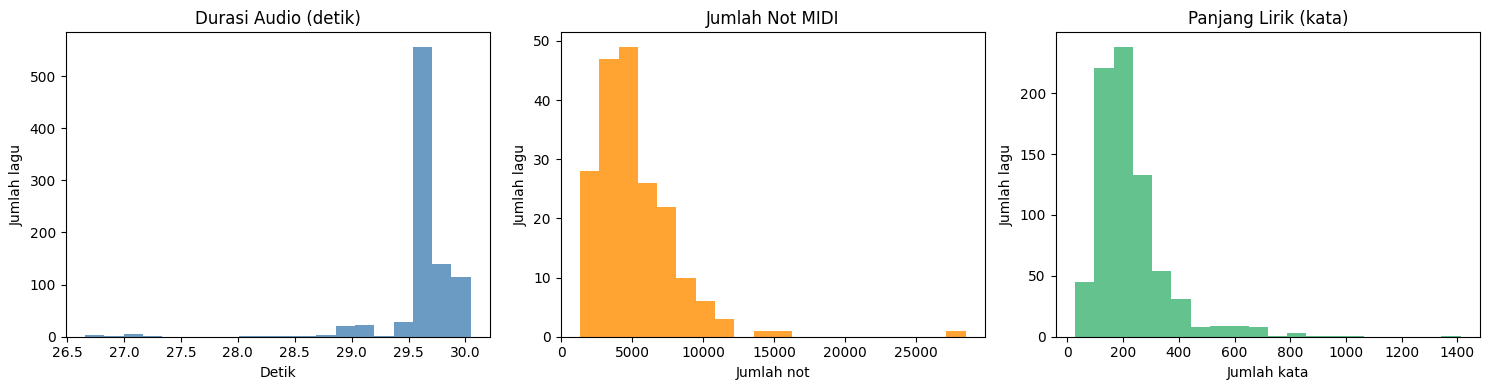

In [42]:
# Ringkasan fitur dasar: durasi audio, jumlah not MIDI, panjang lirik
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(audio_durations, bins=20, color='steelblue', alpha=0.8)
plt.title('Durasi Audio (detik)')
plt.xlabel('Detik')
plt.ylabel('Jumlah lagu')

plt.subplot(1, 3, 2)
if len(midi_note_counts) > 0:
    plt.hist(midi_note_counts, bins=20, color='darkorange', alpha=0.8)
    plt.title('Jumlah Not MIDI')
    plt.xlabel('Jumlah not')
    plt.ylabel('Jumlah lagu')
else:
    plt.text(0.5, 0.5, 'MIDI tidak tersedia', ha='center')
    plt.axis('off')

plt.subplot(1, 3, 3)
if len(lyrics_word_counts) > 0:
    plt.hist(lyrics_word_counts, bins=20, color='mediumseagreen', alpha=0.8)
    plt.title('Panjang Lirik (kata)')
    plt.xlabel('Jumlah kata')
    plt.ylabel('Jumlah lagu')
else:
    plt.text(0.5, 0.5, 'Lirik tidak tersedia', ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 5. Ringkasan & tindak lanjut

In [43]:
# Ringkasan otomatis berbasis hasil di atas
print("=== Ringkasan cepat ===")
print(f"Total entri metadata: {len(metadata)}")
print(f"Audio yang diekstrak: {len(audio_ids)} | MIDI: {len(midi_ids)} | Lirik: {len(lyrics_ids)}")
if len(audio_durations) > 0:
    print(f"Durasi audio median: {np.median(audio_durations):.2f}s")
if len(midi_note_counts) > 0:
    print(f"Jumlah not MIDI median: {np.median(midi_note_counts):.0f}")
if len(lyrics_word_counts) > 0:
    print(f"Panjang lirik median: {np.median(lyrics_word_counts):.0f} kata")
print("Cek kembali sel analisa untuk insight detail dan plot t-SNE.")


=== Ringkasan cepat ===
Total entri metadata: 902
Audio yang diekstrak: 902 | MIDI: 194 | Lirik: 764
Durasi audio median: 29.68s
Jumlah not MIDI median: 4586
Panjang lirik median: 199 kata
Cek kembali sel analisa untuk insight detail dan plot t-SNE.


### ANALISA AKHIR & HIPOTESIS
- **Noise/outlier**: Audio menunjukkan RMS ekstrem (silent/clipping); perlu trim/skip dan normalisasi. MIDI memiliki note_density ekstrem; verifikasi file anomali. Lirik: cek file kosong/encoding.
- **Missing/coverage**: Modal MIDI/lirik tidak lengkap; fokus awal bisa di audio, atau gunakan hanya subset dengan dua modal, lalu align jika ingin multimodal penuh.
- **Imbalance**: Distribusi label/cluster tidak merata; gunakan rebalancing/weighting saat modelling.
- **Pola & kualitas fitur**: t-SNE per modal (dan variasi perplexity 5/20/30/40) masih overlap , fitur dasar (MFCC, TF-IDF, tempo) belum memisah emosi dengan jelas.
- **Hipotesis lanjut**: 
  - Audio: tambah fitur spektral/pitch/tempo kaya atau embedding pretrained (wav2vec/YAMNet); bersihkan outlier RMS. 
  - MIDI: tambah key/interval/entropy lanjutan atau embedding symbolic (MusicBERT); buang MIDI kosong/aneh. 
  - Lirik: pakai embedding kontekstual (mBERT) + lexicon emosi; pastikan teks bersih. 
  - Multimodal: gabung embedding bersih + rebalancing label untuk memperkuat separasi di t-SNE/cluster.
